<a href="https://colab.research.google.com/github/kazueuglena/mimosa_img_process/blob/main/study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# モデル構築のためのプログラム
from google.colab import drive
drive.mount('/content/drive')

!pip install ipython-autotime

import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception
from keras.models import Model, load_model
from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


times = 0
X = []
Y = []

while times <= 180:
    # 入力フォルダと出力フォルダのパス
    folder_path = "/content/drive/MyDrive/cut_mimosa/mimosa_output"
    folder_path = os.path.join(folder_path, str(times))

    # フォルダが存在しない場合は処理をスキップ
    if not os.path.exists(folder_path):
        print(f"フォルダ {folder_path} が存在しません。処理をスキップします。")
        times += 20
        continue

    # フォルダ内のファイルを取得
    file_list = os.listdir(folder_path)
    if file_list:
        for file in file_list:
            image = Image.open(os.path.join(folder_path, file))
            # RGB変換
            image = image.convert('RGB')
            new_size = (350, 585)  # 新しいサイズ (幅, 高さ)
            image = image.resize(new_size)
            # 画像から配列に変換
            # 葉の開き具合を写真の名前の最初に入れ、〜-の形で元の名前と区切る
            data = np.asarray(image)
            file_split = [i for i in file.split('_')]
            # XにNumPy配列形式の画像を追加
            X.append(data)
            # Yに開き具合を代入
            Y.append(float(file_split[0]))

    times += 20

# NumPy配列に変換
X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)



# trainデータとtestデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    random_state = 0,
    test_size = 0.2
)

del X,Y
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# データ型の変換＆正規化　判定の精度を上げるため
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# trainデータからvalidデータを分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    random_state = 0,
    test_size = 0.2
)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)


#ここからCNNの構築開始　モデルEceptionを読み込み　全層結合を削除　input_shapeの値はうまく行かなかったらNoneに
#下に画像のピクセルのサイズを入れないとエラーが起きる
height = 585
width = 350

base_model = Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = (height, width, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1)(x)

#画像データの少なさを補うためのプログラム
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True
)

#学習の進捗状況の監視
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1
)

# ModelCheckpoint
weights_dir = '/content/drive/My Drive/weights/'
if os.path.exists(weights_dir) == False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    #モデルのアーキテクチャと設定を下のプログラムで削除しちゃってるので、うまく行かなかったら＝Falseに変えてみる
    save_weights_only = True,
    period = 3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    #factor の値はモデルに応じて変更　初期値は0.1
    factor = 0.1,
    patience = 3,
    verbose = 1
)

logging = TensorBoard(log_dir = "/content/drive/My Drive/log/")

# 損失関数　RMSEを定義　他にもMSEなどでもいいかも　うまく行かなかったら変更
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

#108層までは固定　エッジングなどの基本的なことをする
for layer in model.layers[:108]:
    layer.trainable = False

    # Batch Normalizationのfreeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True
    if layer.name.endswith('bn'):
        layer.trainable = True

#109層以降、学習させる　オジギソウの画像に合わせて
for layer in model.layers[108:]:
    layer.trainable = True

# layer.trainableの設定後にcompile
model.compile(
    optimizer = Adam(),
    loss = root_mean_squared_error,
)

%load_ext autotime
hist = model.fit_generator(
    #batch_sizeとは一度にCNNに入れるデータの量 (64,128でできるならそっちのほうが精度が高い)　すべてやってみて一番いいやつを使用
    datagen.flow(X_train, y_train, batch_size = 16),
    steps_per_epoch = X_train.shape[0] // 32,
    epochs = 70,
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping, reduce_lr],
    shuffle = True,
    verbose = 1
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(452, 585, 350, 3) (452,)
(361, 585, 350, 3) (361,) (91, 585, 350, 3) (91,)
(288, 585, 350, 3) (288,) (73, 585, 350, 3) (73,)
83683744/83683744 [==============================] - 5s 0us/step


<ipython-input-2-b94d7e3a41c2>:182: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/70
9/9 [==============================] - 36s 2s/step - loss: 61.1552 - val_loss: 396.3065 - lr: 0.0010
Epoch 2/70
9/9 [==============================] - 12s 1s/step - loss: 28.3549 - val_loss: 354.7895 - lr: 0.0010
Epoch 3/70
9/9 [==============================] - 10s 1s/step - loss: 31.7733 - val_loss: 217.0486 - lr: 0.0010
Epoch 4/70
9/9 [==============================] - 11s 1s/step - loss: 24.6398 - val_loss: 110.5881 - lr: 0.0010
Epoch 5/70
9/9 [==============================] - 12s 1s/step - loss: 23.5221 - val_loss: 209.8803 - lr: 0.0010
Epoch 6/70
9/9 [==============================] - 12s 1s/step - loss: 23.8638 - val_loss: 219.3941 - lr: 0.0010
Epoch 7/70
9/9 [==============================] - 12s 1s/step - loss: 24.3546 - val_loss: 101.1110 - lr: 0.0010
Epoch 8/70
9/9 [==============================] - 11s 1s/step - loss: 21.7771 - val_loss: 203.1229 - lr: 0.0010
Epoch 9/70
9/9 [==============================] - 11s 1s/step - loss: 21.2990 - val_loss: 136.8750 - lr:

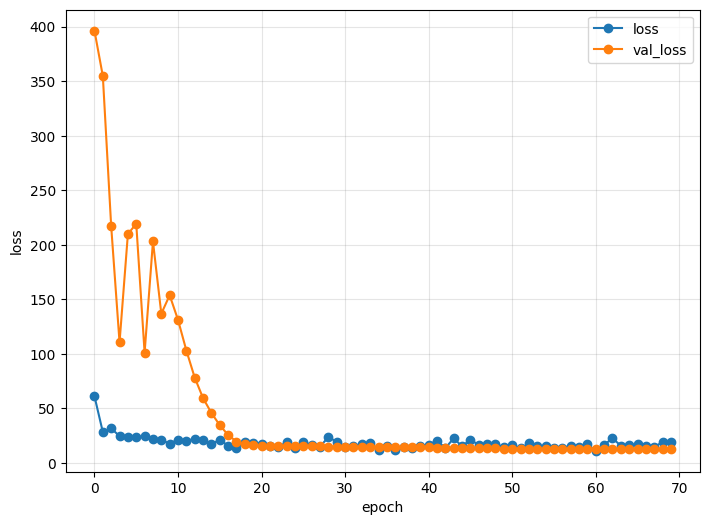

3/3 [==============================] - 7s 3s/step - loss: 14.1086
evaluate loss: 14.108577728271484
evaluate accuracy: 14.108577728271484
time: 10.9 s (started: 2023-07-22 10:02:38 +00:00)


In [ ]:
import matplotlib.pyplot as plt

#学習したモデルの結果を表すためのグラフ
#エポック数が横軸、精度が縦軸

plt.figure(figsize=(18,6))

# loss
plt.subplot(1, 2, 1)
plt.plot(hist.history["loss"], label="loss", marker="o")
plt.plot(hist.history["val_loss"], label="val_loss", marker="o")
#plt.yticks(np.arange())
#plt.xticks(np.arange())
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("")
plt.legend(loc="best")
plt.grid(color='gray', alpha=0.2)

plt.show()


#学習の損失　正解率を表すプログラム
#うまく動かなかったらhttps://qiita.com/ha9kberry/items/314afb56ee7484c53e6f のモデル評価を参照
score = model.evaluate(X_test, y_test, verbose=1)
# テストデータセットでのモデルの評価
print("evaluate loss: {}".format(score))  # 損失の表示
print("evaluate accuracy: {}".format(score))  # 正解率の表示

In [ ]:
#モデルの保存
from google.colab import drive
drive.mount('/content/drive')

import os
model_dir =  "/content/drive/MyDrive/model"
if os.path.exists(model_dir) == False : os.mkdir(model_dir)

model.save(model_dir + '/model.hdf5')

# optimizerのない軽量モデルを保存（学習や評価不可だが、予測は可能）
model.save(model_dir + '/0722model.hdf5', include_optimizer = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 13.2 s (started: 2023-07-22 10:05:17 +00:00)


1/1 [==============================] - 8s 8s/step


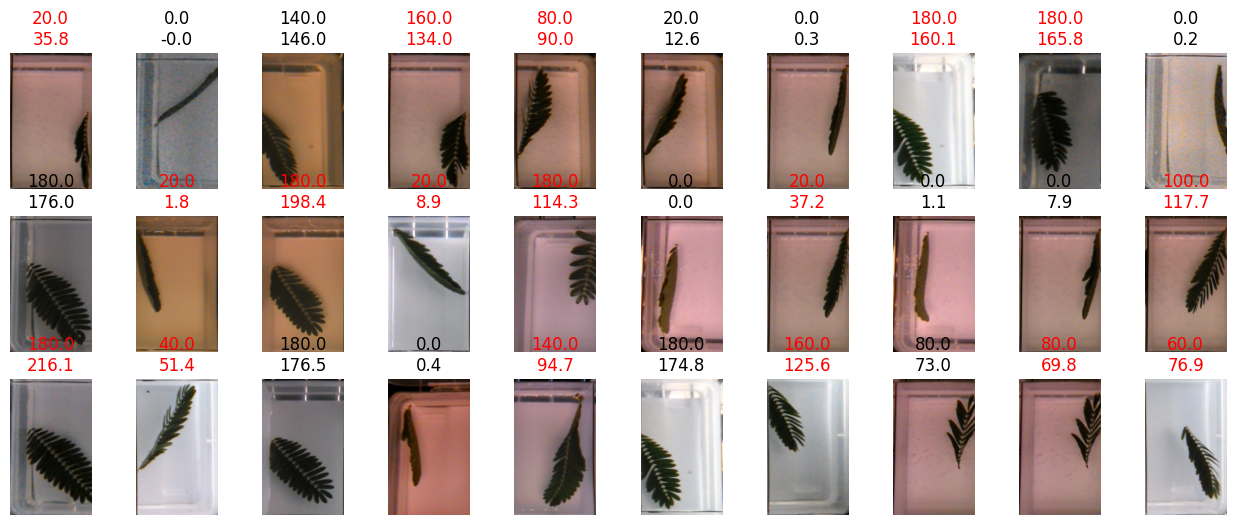

time: 15.2 s (started: 2023-07-22 10:02:59 +00:00)


In [ ]:
#学習の精度と写真を整合
# testデータ30件の予測値
preds=model.predict(X_test[0:30])

# testデータ30件の画像と正解値＆予測値を出力
plt.figure(figsize=(16, 6))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.axis("off")
    pred = round(preds[i][0],1)
    true = y_test[i]
    #この5.4という値は適宜変更しても大丈夫　表示の問題だけ
    if abs(pred - true) < 10:
        plt.title(str(true) + '\n' + str(pred))
    else:
        plt.title(str(true) + '\n' + str(pred), color = "red")
    plt.imshow(X_test[i])
plt.show()



https://note.com/keisuke_funabiki/n/n66d080741f5b